<h1 align="center"> Computation for Physicists </h1>
<h2 align="center"> <em>Partial Differential Equations</em> </h2>
<h2 align="center" > <a href="mailto:duan@unm.edu">Dr. Duan</a> (UNM) </h2>

# Homework 14

Use [`scipy.integrate.solve_bvp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html) to find two distinct solutions to $y''(x)=3y^2/2$ with $y(0)=4$ and $y(1)=1$.

[[Wikipedia]](https://en.wikipedia.org/wiki/Shooting_method)

![](https://upload.wikimedia.org/wikipedia/commons/f/f0/Shooting_method_trajectories.svg)

In [1]:
import numpy as np
from scipy.integrate import solve_bvp
xi = 0; xf = 1; yi = 4; yf = 1 # boundary conditions

# convert to the ODE to 1st order
dudx = lambda x, u: np.array([u[1], 1.5 * u[0]**2])
# construct boundary conditions
bc = lambda ui, uf: np.array([ui[0]-yi, uf[0]-yf]) 
x0 = np.linspace(xi, xf, 10) # initial mesh
# initial guess of u, linear y
u0 = np.empty((2,len(x0)), dtype=np.float64)
u0[0,:] = xi + (x0-xi)*(yf-yi)/(xf-xi) 
u0[1,:] = (yf-yi)/(xf-xi) 
sol1 = solve_bvp(dudx, bc, x0, u0)
assert sol1.success, sol1.message # check if the solution is found

In [2]:
# another initial guess of u, quadratic y
u0[0,:] += 32*(x0-0.5)**2 - 8
u0[1,:] += 64*(x0-0.5)  
sol2 = solve_bvp(dudx, bc, x0, u0)
assert sol2.success, sol2.message # check if the solution is found

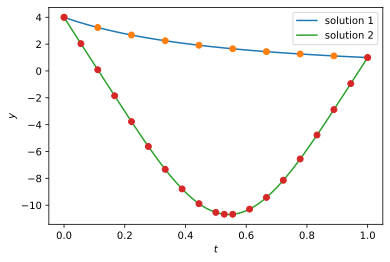

In [3]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg') # make sharp images

t = np.linspace(xi, xf, 100) # mesh for plotting
plt.plot(t, sol1.sol(t)[0], label='solution 1')
plt.plot(sol1.x, sol1.y[0], 'o') # final collocation points
plt.plot(t, sol2.sol(t)[0], label='solution 2')
plt.plot(sol2.x, sol2.y[0], 'o') # final collocation points

plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend()
plt.show()

# Partial Differential Equations

- **Partial differential equations (PDEs)** involve partial derivatives with respect to more than one variables.

- A PDE can be an initial value problem, a boundary value problem, or a mixture of the two. The boundary can be irregular.

- The **order** of a PDE is the order of the highest-order derivative in the equation.

- An example of 1st order PDE: $ u_t + v u_x = 0 $ (advection equation), where $u_t = \partial u/\partial t$ and $u_x = \partial u/\partial x$.



# Classification of 2nd Order PDEs

$$ a u_{xx} + b u_{x y} + c u_{yy} + d u_x + e u_y + f u + g =0 $$

- **Hyperbolic PDEs** ($b^2 -4 a c>0$) describe time-dependent, _conservative_ processes such as wave propagation that are not evolving toward steady states. Example: $u_{tt}-v^2 u_{zz}=0$ (wave equation).
- **Parabolic PDEs** ($b^2 - 4 a c = 0$) describe time-dependent, _dissipative_ processes such as heat diffusion that are evolving toward steady states. Example: $u_{t}-\kappa u_{zz}=0$ (heat equation).
- **Elliptic PDEs** ($b^2-4ac<0$) describe time-independent steady states. Example: $u_{xx} + u_{yy}=0$ (Laplace equation).

# Time-Dependent PDEs: Semidiscrete Methods
- Solve the heat equation $u_t = u_{xx}$ for $x\in[0,1]$ with the initial condition $u(0,x)=f(x)$ and boundary conditions $u(t,0)=g(t)$ and $u(t,1)=h(t)$.
    - Define $N$ spatial mesh points $x_i = i\Delta x$ ($i=0,1,\ldots,N-1$) with $\Delta x=1/(N-1)$. Let $y_i(t)$ be the numerical solution at $(t, x_i)$. The boundary conditions are $y_0(t)=g(t)$, and $y_{N-1}(t)=h(t)$, and the initial conditions are $y_i(0)=f(x_i)$.
    - Use the central difference approximation to convert the PDE to a system of ODEs:
    $$ y'_i(t) = \frac{y_{i+1}(t) - 2y_i(t) + y_{i-1}(t)}{(\Delta x)^2}
    \quad(i=1,\ldots,N-2).$$
    - Solve the ODEs with [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

In [4]:
class HeatEquation:
    def __init__(self, f, g, h, x):
        '''f, g, h: initial and boundary conditions.
        x: mesh points including the boundary points.
        '''
        self.g = g; self.h = h # boundary conditions
        self.y_ini = np.array([f(xi) for xi in x[1:-1]]) # initial values
        coe = (x[1] - x[0])**(-2) # coefficient for equation
        n = len(x) - 2 # number of interior points
        def eq(t, y): # dy/dt on interior points
            dydt = np.empty(n, dtype=np.float64)
            dydt[0] = coe*(self.g(t)-2*y[0]+y[1]) # point next to the left boundary
            dydt[-1] = coe*(y[-2]-2*y[-1]+self.h(t)) # point next to the right boundary
            dydt[1:-1] = coe*(y[:-2]-2*y[1:-1]+y[2:]) # rest of the interior points
            return dydt
        self.dydt = eq 
        
    def __call__(self, t, method='RK45'):
        from scipy.integrate import solve_ivp
        sol = solve_ivp(self.dydt, (0, t), self.y_ini, method=method)
        assert sol.success, sol.message # check if the solution is found
        return np.concatenate(([self.g(t)], sol.y[:,-1], [self.h(t)])) # include boundary

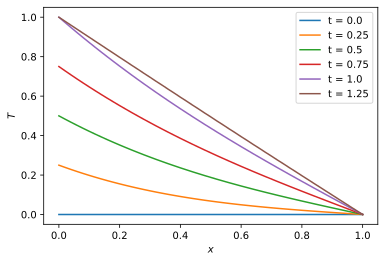

In [5]:
f = lambda x: 0
g = lambda t: t if t < 1 else 1
h = lambda t: 0

n = 51; x = np.linspace(0, 1, n) # spatial mesh
T = HeatEquation(f, g, h, x) # temperature distribution
for t in np.arange(0, 1.5, 0.25):
    plt.plot(x, T(t), label=f't = {t}')
plt.xlabel('$x$')
plt.ylabel('$T$')
plt.legend()
plt.show()

- When $y_0(t)=y_{N-1}(t)=0$, the semidiscrete system can be written as
$$ \mathbf{y}' = \frac{1}{(\Delta x)^2}
\begin{bmatrix}
-2 & 1 & 0 & \cdots & 0 \\
1 & -2 & 1 & \cdots & 0 \\
0 & 1 & -2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots -2
\end{bmatrix} \begin{bmatrix}
y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_{N-2}
\end{bmatrix}
= \mathbf{A} \mathbf{y}. $$
Jocabian matrix $\mathbf{A}$ has eigenvalues between $-4/(\Delta x)^2$ and 0 which makes the system very stiff as $\Delta x$ decreases.

# Time-Dependent PDEs: Fully Discrete Methods

- Both time and spatial dimensions are discretized in the **fully discrete methods**.

- Example: With the time derivative approximated by Euler's method and $u_{xx}$ by the central difference, $u_t = u_{xx}$ becomes
$$ u_{j,n+1} = u_{j,n} + \frac{\Delta t}{(\Delta x)^2}(u_{j+1,n}-2u_{j,n}+u_{j-1,n}), $$
where $u_{j,n}$ is the numerical solution at $(t_n, x_j)$ with $t_n=n\Delta t$ and $x_j=j\Delta x$. It has the following **stencil** (i.e. the pattern of the mesh points involved at each step):
![](https://upload.wikimedia.org/wikipedia/commons/c/c2/Explicit_method-stencil.svg)

- The stiffness of the equations limits the time step of the explicit methods.

- Using the backward Euler method for the time integration one obtains 
$$ u_{j,n+1} = u_{j,n} + \frac{\Delta t}{(\Delta x)^2}(u_{j+1,n+1}-2u_{j,n+1}+u_{j-1,n+1}), $$
which is implicit and has the stencil
![](https://upload.wikimedia.org/wikipedia/commons/c/c6/Implicit_method-stencil.svg)

- **The Crank-Nicolson method** uses the trapzoid method for the time integration:
$$ u_{j,n+1} = u_{j,n} + \frac{\Delta t}{2(\Delta x)^2}(u_{j+1,n+1}-2u_{j,n+1}+u_{j-1,n+1}
+u_{j+1,n}-2u_{j,n}+u_{j-1,n}) $$
which has the stencil
![](https://upload.wikimedia.org/wikipedia/commons/1/1e/Crank-Nicolson-stencil.svg)

- In the Crank-Nicolson method, $u_{j,n+1}$ can be solved from
\begin{align} 
&\quad\begin{bmatrix}
1+2\alpha & -\alpha & 0 & \cdots & 0 \\
-\alpha & 1 + 2\alpha & -\alpha & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 1+2\alpha 
\end{bmatrix} \begin{bmatrix}
u_{1,n+1} \\ u_{2,n+1} \\ \vdots \\ u_{N-2,n+1}
\end{bmatrix}\\
&= \begin{bmatrix}
\alpha u_{0,n} + (1-2\alpha)u_{1,n} + \alpha u_{2,n} \color{red}{+ \alpha u_{0,n+1}} \\
\alpha u_{1,n} + (1-2\alpha)u_{2,n} + \alpha u_{3,n} \\
\vdots \\
\alpha u_{N-3,n} + (1-2\alpha)u_{N-2,n} + \alpha u_{N-1,n} \color{red}{+ \alpha u_{N-1,n+1}}
\end{bmatrix}, 
\end{align}
where $\alpha=\Delta t/2(\Delta x)^2$. This banded linear system can be solved by using [`scipy.linalg.solve_banded`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html).

In [6]:
class HeatEquation2:
    def __init__(self, f, g, h, x, t):
        '''f, g, h: initial and boundary conditions.
        x, t: spatial and temporal mesh points including the boundaries.
        '''
        a = 0.5 * (t[1]-t[0]) / (x[1] - x[0])**2 # coefficent alpha
        Nx = len(x); Nt = len(t) # number of mesh points
        self.u = np.empty((Nx, Nt), dtype=np.float64) 
        self.u[1:-1, 0] = np.array([f(xi) for xi in x[1:-1]]) # initial values
        self.u[0, :] = np.array([g(tn) for tn in t]) # left boundary
        self.u[-1, :] = np.array([h(tn) for tn in t]) # right boundary
        # construct the linear system to solve u
        A = np.empty((3,Nx-2))
        A[1, :] = 1+2*a # diagonal elements of the matirx
        A[0, :] = A[2, :] = -a # off-diagonal elements
        from scipy.linalg import solve_banded
        for n in range(Nt-1):         # solve u at step n+1
            b = a * (self.u[:-2, n] + self.u[2:, n]) + (1-2*a) * self.u[1:-1, n]
            b[0] += a * self.u[0, n+1]
            b[-1] += a * self.u[-1, n+1]
            self.u[1:-1, n+1] = solve_banded((1,1), A, b)

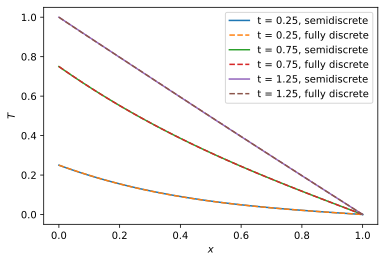

In [7]:
x = np.linspace(0, 1, 51) # spatial mesh
t = np.linspace(0, 1.25, 21) # temporal mesh
T = HeatEquation(f, g, h, x) # semi-discrete solution
T2 = HeatEquation2(f, g, h, x, t) # fully discrete solution
for n in range(4,len(t),8): # compares the two solutions
    plt.plot(x, T(t[n]), label=f't = {t[n]}, semidiscrete')
    plt.plot(x, T2.u[:,n], '--', label=f't = {t[n]}, fully discrete')
plt.xlabel('$x$')
plt.ylabel('$T$')
plt.legend()
plt.show()

# Time-Independent PDEs

- Unlike time-dependent problems, the solution to the time-independent PDEs cannot be produced by marching forward step by step in time but needs to be established simultaneously.

- There are different types of boudnary conditions:
    - The **Dirichlet boundary conditions** specify the values of $u$ at the boundary points.
    - The **Neumann boundary conditions** specify the derivatives of $u$ at the boundary points.
    - A mixture of the two.

Example: Find the energy eigenvalues of a quantum particle confined in a 2D square box. This problem is equivalent to solving the following equation 
$$ u_{xx} + u_{yy} + \omega u = 0 $$
with the boundary conditions $u(0,y) = u(1,y) = u(x,0) = u(x,1)=0$.
- Define mesh points $x_i=i h$ and $y_j=j h$ with $h=1/(N-1)$ and $i,j=0,1,\ldots,N-1$.

- Use the central difference to convert the PDE to a linear system:
$$ \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2} + \frac{u_{i,j+1}-2u_{i,j} + u_{i,j-1}}{h^2} + \omega u_{i,j} = 0, $$
where $u_{i,j}$ approximates $u(x_i, y_j)$.

- Combine the indices $(i,j)\rightarrow k$ and solve the eigen system $\mathbf{H}\mathbf{u}=\omega\mathbf{u}$.


In [16]:
class ParticleInSquare:
    def __init__(self, n):
        'n: number of mesh points along each dimension.'
        n = n - 2 # number of interior points
        H = np.zeros((n**2, n**2), dtype=np.float64) # Hamiltonian
        h = 1 / (n+1) # mesh point interval
        Hdiag = 4 / h**2 # diagonal elements
        Hoff = -1 / h**2 # off-diagonal elements
        for i in range(n):
            for j in range(n):
                k = i*n + j # index of the current row
                H[k, k] = Hdiag # diagonal element
                if i > 0: H[k, k-n] = Hoff # contribution from u(i-1,j)
                if i < n-1: H[k, k+n] = Hoff # contribution from u(i+1,j)
                if j > 0: H[k, k-1] = Hoff*(1+1e-6) # contribution from u(i,j-1)
                if j < n-1: H[k, k+1] = Hoff*(1+1e-6) # contribution from u(i,j+1)
        from scipy.linalg import eigh
        w, v = eigh(H)
        self.w = w[:n] # save n lowest energy values
        self.psi = np.zeros((n, n+2, n+2)) # energy wavefunctions
        self.psi[:, 1:-1, 1:-1] = v.T[:n,:].reshape((n, n, n))

In [17]:
particle = ParticleInSquare(21) # mesh interval = 1/20
particle.w[:16] # first 16 energy eigenvalues

array([ 19.6978649 ,  49.00332434,  49.00335364,  78.30881308,
        97.04331802,  97.04339537, 126.34880677, 126.34885481,
       162.63494187, 162.63508481, 174.38884849, 191.94043062,
       191.94054425, 239.98047234, 239.98053794, 244.16311242])

In [18]:
# exact values of the first 16 energy levels
np.sort([(k*np.pi)**2 + (q*np.pi)**2 for k in range(1,5) for q in range(1,5)])

array([ 19.7392088 ,  49.34802201,  49.34802201,  78.95683521,
        98.69604401,  98.69604401, 128.30485721, 128.30485721,
       167.78327482, 167.78327482, 177.65287922, 197.39208802,
       197.39208802, 246.74011003, 246.74011003, 315.82734083])

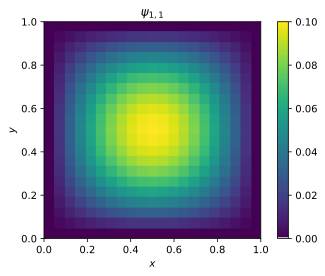

In [19]:
# ground state wavefunction
plt.imshow(particle.psi[0], origin='lower', extent=(0, 1, 0, 1))
plt.colorbar()
plt.title('$\psi_{1,1}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

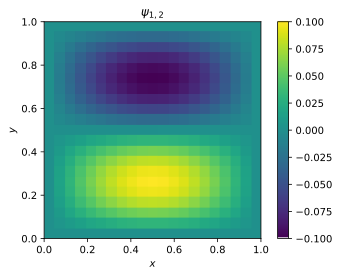

In [20]:
# wavefunction of one of two first excited states
plt.imshow(particle.psi[1], origin='lower', extent=(0, 1, 0, 1))
plt.colorbar()
plt.title('$\psi_{1,2}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

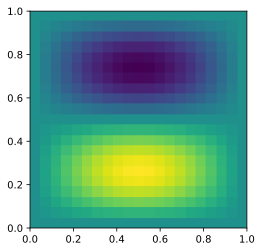

In [15]:
def psi(n, m, x, y):
    'Wave function (x,y) with energy quantum numbers (n, m).'
    return np.sin(n*np.pi*x) * np.sin(m*np.pi*y.reshape((-1,1)))

x = np.linspace(0, 1, 21) # x mesh points
y = np.linspace(0, 1, 21) # y mesh points
plt.imshow(psi(1,2,x,y), origin='lower', extent=(0, 1, 0, 1))

# Other Techniques

- Spatial discretization can also be achieved by expressing the solution as the linear combination of a set of basis functions, e.g. $u(t, x) \approx v(t,x) \equiv \sum_{i=0}^{N-1} \alpha_i(t) \phi_i(x)$ for $\hat{L} u(t,x) = f(t,x)$.
    - The basis functions $\phi_i(x)$ can be either of global support (e.g. the Fourier series), which yields the spectral method, or of local support (e.g. the B-splines), which gives the finite element method. The elements in the finite element method can be triangles or quadrilaterals in 2D, and tetrahedra or hexahedra in 3D.
    - The coefficients $\alpha_i(x)$ can be determined by forcing $v(t, x)$ to satisfy the PDE exactly on $N$ collocation points (collocation method) or making the residue function ($\hat{L}v - f$) to be orthogonal to all the basis functions employed (Galerkin method).

<h1 align="center"> Thanks You! </h1>